# Create a basic optimization model

In this example, we explain the basic functions of the linopy Model class. First, we are setting up a very simple linear optimization model, given by 

     Minimize:
$$ x + 2y $$
      
     subject to:
$$ x \ge 0 $$
$$y \ge 0 $$
$$3x + 7y \ge 10 $$
$$5x + 2y \ge 3 $$


In [1]:
from linopy import Model

In [2]:
m = Model()

The Model class serves at a container for all the relevant data. 

### Adding variables

Let's add the two variables. Note that a variable can always be assigned with a lower and an upper bound. In this case, both `x` and `y` have a lower bound of zero (coming from the first two constraints). Note, the default for lower and upper bounds are minus and plus infinity.

In [3]:
x = m.add_variables('x', lower=0)
y = m.add_variables('y', lower=0);

`x` and `y` are linopy variables. Each of them consist of an array with the variable references in the model, that is the names of variables that will finally be used when solving the model. 

In [4]:
x

Variable container:
-------------------

Variables:
array(1)
Attributes:
    name:     x

Since both `x` and `y` are scalar variables, so their arrays also contain just one variable reference. The variable `x` points to the optimisation variable 1 and the variable `y` points to the optimisation variable 2. Later we will see the benefit of this behaviour.  

### Adding Constraints

Constraints consist of the left hand side (lhs) and the righ hand side (rhs). The lhs must contain all the variables with the corresponding coefficients, while the rhs is just constant. The first lhs of our two remaining constraints is 
$3x + 7y$, which we can write just exaclty in this way

In [5]:
3*x + 7*y

Linear Expression with 2 term(s):
----------------------------------

Dimensions:  (term_: 2)
Coordinates:
  * term_    (term_) int64 0 1
Data:
    coeffs   (term_) int64 3 7
    vars     (term_) int64 1 2

When assigning to the model, we call the function `m.add_constraints`.

In [6]:
m.add_constraints('Constraint1', 3*x + 7*y, '>=', 10)
m.add_constraints('Constraint2', 5*x + 2*y, '>=', 3);

## Adding the Objective 

We do the same for defining the objective while the objective function only consists of a linear expression.

In [7]:
m.add_objective(x + 2*y)

Linear Expression with 2 term(s):
----------------------------------

Dimensions:  (term_: 2)
Coordinates:
  * term_    (term_) int64 0 1
Data:
    coeffs   (term_) int64 1 2
    vars     (term_) int64 1 2

In [8]:
m.solve(solver_name='gurobi')

Academic license - for non-commercial use only - expires 2021-04-18
Using license file /opt/gurobi911/gurobi.lic
Read LP format model from file /tmp/linopy-problem-puevgf1v.lp
Reading time = 0.01 seconds
obj: 2 rows, 2 columns, 4 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 2 rows, 2 columns and 4 nonzeros
Model fingerprint: 0x4c5ee539
Coefficient statistics:
  Matrix range     [2e+00, 7e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 1e+01]
Presolve time: 0.01s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.625000e+00   0.000000e+00      0s
       2    2.8620690e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds
Optimal objective  2.862068966e+00


Linopy model

Variables:
----------
Dimensions:  ()
Data:
    x        int64 1
    y        int64 2

Constraints:
------------
Dimensions:      ()
Data:
    Constraint1  int64 1
    Constraint2  int64 2

Status:
-------
optimal

The solution of the linear problem is stored in `m.solution` in fom of a `xarray.Dataset`. 

In [9]:
m.solution

<xarray.Dataset>
Dimensions:  ()
Data variables:
    x        float64 0.03448
    y        float64 1.414

## Expanding the dimensionality

Now comes the interesting part. Suppose the two variables `x` and `y` are a function of time `t` and a modified problem setup like 

Minimize:
$$\sum_t x_t + 2 y_t$$
subject to:
$$
x_t \ge 0 \qquad \forall t \\
y_t \ge 0 \qquad \forall t \\
3x_t + 7y_t \ge 10 t \qquad \forall t\\
5x_t + 2y_t \ge 3 t \qquad \forall t
$$
whereas `t` spans all the range from 0 to 10.

First, we define a new model (we just overwrite the old `m`).

In [10]:
m = Model()

Again, we define `x` and `y` using the `add_variables` function, but now we are adding a `coords` argument. This automatically creates optimization variables for all coordinates, in this case time-steps.

In [11]:
import pandas as pd
time = pd.Index(range(10), name='time')

x = m.add_variables(name='x', lower=0, coords=[time])
y = m.add_variables(name='y', lower=0, coords=[time])

We again write the contraints out using the syntax from above, while multiplying the rhs with `t`. Note that the coordinates from the lhs and the rhs have to match. 

*Note: In case lhs and rhs have different sets of coordinates, the constraint creation is broadcasted over all combinations of coordinates.*

In [12]:
factor = pd.Series(time, index=time)

m.add_constraints('Constraint1', 3*x + 7*y, '>=', 10*factor)
m.add_constraints('Constraint2', 5*x + 2*y, '>=', 3*factor)
m

Linopy model

Variables:
----------
Dimensions:  (time: 10)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9
Data:
    x        (time) int64 1 2 3 4 5 6 7 8 9 10
    y        (time) int64 11 12 13 14 15 16 17 18 19 20

Constraints:
------------
Dimensions:      (time: 10)
Coordinates:
  * time         (time) int64 0 1 2 3 4 5 6 7 8 9
Data:
    Constraint1  (time) int64 1 2 3 4 5 6 7 8 9 10
    Constraint2  (time) int64 11 12 13 14 15 16 17 18 19 20

Status:
-------
initialized

When we add the objective, we use the `sum` function of `linopy.LinearExpression`. This stacks the `term_` dimension, such that all terms of the `time` dimension are rewritten into one big expression. 

In [13]:
obj = (x + 2*y).sum()
m.add_objective(obj)

Linear Expression with 20 term(s):
----------------------------------

Dimensions:  (term_: 20)
Coordinates:
  * term_    (term_) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Data:
    coeffs   (term_) int64 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2
    vars     (term_) int64 1 11 2 12 3 13 4 14 5 15 6 16 7 17 8 18 9 19 10 20

In [14]:
m.solve();

Read LP format model from file /tmp/linopy-problem-9drgkw2d.lp
Reading time = 0.00 seconds
obj: 20 rows, 20 columns, 40 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 20 rows, 20 columns and 40 nonzeros
Model fingerprint: 0x89bb3e20
Coefficient statistics:
  Matrix range     [2e+00, 7e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 9e+01]
Presolve removed 2 rows and 2 columns
Presolve time: 0.01s
Presolved: 18 rows, 18 columns, 36 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   7.312500e+01   0.000000e+00      0s
      18    1.2879310e+02   0.000000e+00   0.000000e+00      0s

Solved in 18 iterations and 0.01 seconds
Optimal objective  1.287931034e+02


<AxesSubplot:xlabel='time', ylabel='Optimal Value'>

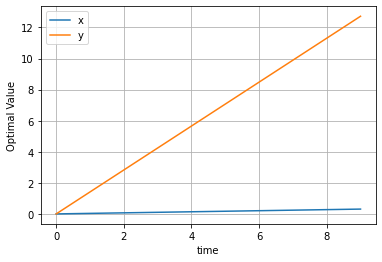

In [15]:
m.solution.to_dataframe().plot(grid=True, ylabel='Optimal Value')

You can easily add dimensions in this way. Since the underlying code is highly relying on `xarray` broadcasting on new dimesions is automatically supported, so even the `rhs` can introduce new dimensions. Just be carefull that all variable dimensions have the correct dimension name. 

We limit the slope of the `y` variable by adding a constraint in the form of 
$$ y_{t} - y_{t-1} \le 0.5 \qquad \forall t \ge 1$$

In [16]:
lhs = (y - y.shift(time=1)).sel(time=time[1:])
m.add_constraints('Limited growth y', lhs, '<=', 0.5)

<xarray.DataArray (time: 9)>
array([21, 22, 23, 24, 25, 26, 27, 28, 29])
Coordinates:
  * time     (time) int64 1 2 3 4 5 6 7 8 9
Attributes:
    name:     Limited growth y

Read LP format model from file /tmp/linopy-problem-3sibbb8w.lp
Reading time = 0.00 seconds
obj: 29 rows, 20 columns, 58 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 29 rows, 20 columns and 58 nonzeros
Model fingerprint: 0xbd65942b
Coefficient statistics:
  Matrix range     [1e+00, 7e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 9e+01]
Presolve removed 2 rows and 1 columns
Presolve time: 0.01s
Presolved: 27 rows, 19 columns, 54 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   7.312500e+01   0.000000e+00      0s
      19    1.4158621e+02   0.000000e+00   0.000000e+00      0s

Solved in 19 iterations and 0.01 seconds
Optimal objective  1.415862069e+02


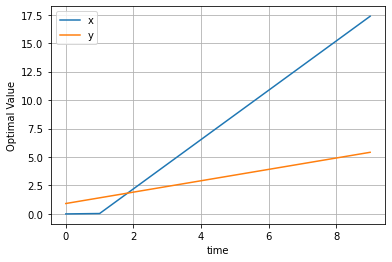

In [17]:
m.solve()
m.solution.to_dataframe().plot(grid=True, ylabel='Optimal Value');